<a href="https://colab.research.google.com/github/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/FnB_CPG_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Optimizing Vending Machine Inventory with AI: A Deep Dive into Model Selection

### Introduction:
Vending machines, once simple dispensers, are evolving into data-driven hubs. To maximize customer satisfaction and revenue, owners need real-time insights into product consumption. This article explores how Vision AI can enhance inventory management by using cameras to monitor purchases.

### The Challenge:
Traditional inventory methods often rely on manual checks or unreliable sensors. Vision AI offers a more accurate and efficient solution. However, the diversity of products in vending machines, coupled with varying package sizes and shapes, presents a unique challenge.

### The Solution: Deep Learning
Deep learning, a subset of AI, is ideally suited for this task. It can learn complex patterns from vast datasets, making it capable of identifying and classifying products even in the face of variations.

### Beyond the model: The Vision AI stack
While the AI model is crucial, it is part of the larger vision AI solution stack. Key components include:
1. Hardware Selection: Choosing the right camera with desired FoV that can capture high quality images in various lighting conditions
2. Hardware Installation: Ensuring cameras are securely mounted and positioned to capture optimal product views without being intrusive or compromising customer experience.
3. Data Transmission: Selecting reliable communication mechanism to transmit image/video data to the processing system
4. Processing System: Determining whether to run the AI model on-device (edge computing) or in the cloud or in a hybrid fashion.
5. Data Storage: Saving necessary data to support future analysis and reporting
6. Data Presentation: Helping owners visualize the insights via a front-end application

### AI Model Development: A Detailed Breakdown

To accurately track product purchases, we need a reference database containing images and corresponding information for each product in the vending machine, including product name and location within the machine. Our motion-detection camera captures footage whenever a customer makes a purchase. By analyzing the movement of the product from its slot, we can effectively identify the specific item purchased.

We have several AI model architectural options to identify products in the image:

**Option 1. Region Proposal -> Object Classification -> OCR**

A Region proposal algorithm will generate a list of object regions/bounding boxes to feed to Object classification. The classes could be [A chips package, A snack bar, A juice bottle]. The classified objects can be passed through an Optical Character Recognition (OCR) model to read the package label and identify specific proudcts.


## Object Detection Model
In order to determine whether I can use an existing pre-trained AI model as-is for my application or will I have to train or fine-tune a model, I had to evaluate the top performing models. Many object detectors use 2 stages, first generating object proposals to identify regions of interest (RoIs) in an image using one AI model and then passing these regions to a classification model to classify them. One stage methods prioritize inference speed over detection accuracy. Below are top 2 detector models:
1. YOLO (You only look once) - single stage detector
2. Faster R-CNN  - Two-stage detector

Let's quickly evaluate how these pre-trained versions of the above models perform for this application that requires detecting packaged food and beverages.

/Users/mukund/Documents/HealthyYouVendingProject
/Users/mukund/Documents/HealthyYouVendingProject


/opt/homebrew/Cellar/jupyterlab/4.2.3/libexec/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Note: you may need to restart the kernel to use updated packages.
vending2.jpg already exists, skipping download
vending2.jpg dim: (1471, 1286)
vending3.jpg already exists, skipping download
vending3.jpg dim: (1300, 1300)
vending5.jpg already exists, skipping download
vending5.jpg dim: (1200, 1600)
vending3-1.jpg already exists, skipping download
vending3-1.jpg dim: (519, 781)
vending5-1.jpg already exists, skipping download
vending5-1.jpg dim: (807, 1304)


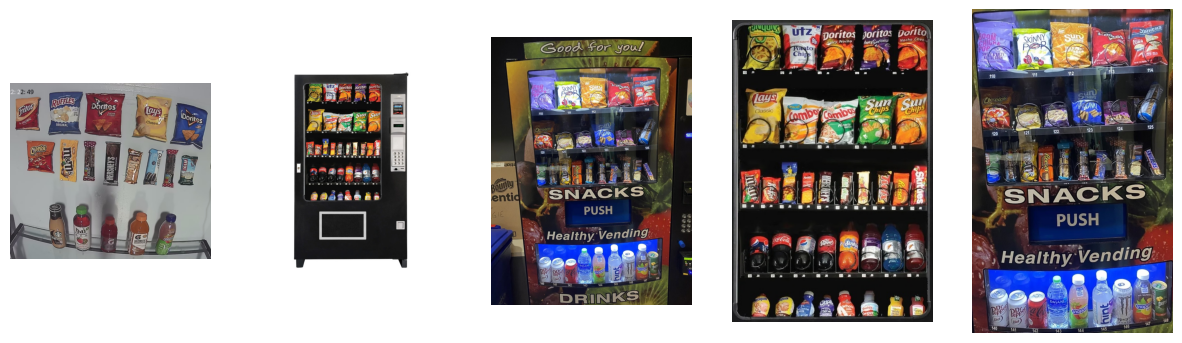

In [199]:
#@title Load Image file
from pathlib import Path
import os

# In general, use ! if the command is one that's okay to run in a separate shell.
# Use % if the command needs to be run on the specific notebook.
if os.environ.get('HOME') == "/Users/mukund":
  %cd '/Users/mukund/Documents/HealthyYouVendingProject'
!pwd

if not 'wget' in os.popen('which wget').read():
  %pip install wget
else:
  print("wget is already installed")

img_fnames = ["vending2.jpg", "vending3.jpg", "vending5.jpg", "vending3-1.jpg", "vending5-1.jpg"]

images = []
for img_fname in img_fnames:
  if Path(img_fname).is_file():
    print(f"{img_fname} already exists, skipping download")
  else:
    print(f"Downloading {img_fname}")
    !wget https://github.com/mukund-rajukumar/My-VisionAI-Projects/blob/main/FoodAndBevPackageDetection/images/{img_fname}

  images.append(Image.open(img_fname))
  print(f"{img_fname} dim: {images[-1].size}")

num_images = len(images)

plt.subplots(nrows=1, ncols=num_images, figsize=(15, 15))

for i, image in enumerate(images):
  plt.subplot(1, num_images, i+1)
  plt.imshow(image)
  plt.axis('off')

plt.show()

In [200]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

#@title Utility Functions
def count_params(model):
  total_params = 0
  for param in model.parameters():
    num_elements = 1
    for dim in param.size():
      num_elements *= dim
    total_params += num_elements
  print(f"{total_params / 1000000:.1f} million parameters")

def plot_yolo_results(results):
  # Process results list
  for result in results:
      boxes = result.boxes  # Boxes object for bounding box outputs
      masks = result.masks  # Masks object for segmentation masks outputs
      keypoints = result.keypoints  # Keypoints object for pose outputs
      probs = result.probs  # Probs object for classification outputs
      obb = result.obb  # Oriented boxes object for OBB outputs
      # result.show()  # display to screen
      result.save(filename="result.jpg")  # save to disk
      res_img = Image.open("result.jpg")
      plt.imshow(res_img)
      plt.show()

# Non-Maximum Suppression: Filter overlapping bounding boxes based on their confidence scores
def nms(dets, thresh):
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    scores = dets[:, 4]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

# Reference: https://github.com/rbgirshick/py-faster-rcnn/blob/master/tools/demo.py
def vis_detections(im, dets, thresh=0.5, caption=None):
    """Draw detected bounding boxes."""
    inds = np.where(dets[:, -1] >= thresh)[0]
    if len(inds) == 0:
        return

    top_idx = dets[:, -1].argmax()

    _, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]

        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red' if i == top_idx else 'green', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:.3f}'.format(score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    if caption is not None:
        plt.title(caption, fontsize=20)
    plt.show()

import time
def make_api_call(prompt, image, model):
  """Calls a Large Language Model (LLM) API to generate text based on a prompt and image.

  Args:
      prompt (str): The text prompt for the LLM.
      image (Image.Image): The image to be analyzed by the LLM.

  Returns:
      genai.TextGenerationResponse: The response object from the LLM API.
  """
  try:
    response = model.generate_content([prompt, image])
    return response
  except Exception as e:
    if e.code == 429:
      print ("Rate Limit Error")
      # Implement retry logic or handle the error appropriately
      return handle_rate_limit_error(prompt, image)

    # Handle other exceptions or return None if no response is available
    print(f"An error occurred: {e}")
    return None

def handle_rate_limit_error(prompt, image):
  """Handles rate limit errors from the LLM API by implementing a retry logic.

  Args:
      prompt (str): The text prompt for the LLM.
      image (Image.Image): The image to be analyzed by the LLM.

  Returns:
      genai.TextGenerationResponse: The response object from the LLM API after retrying.
  """
  time.sleep(60)
  return model.generate_content([prompt, image])

#@title Parse the LLM output to translate to a DictList and plot results
import re
import matplotlib.pyplot as plt

def parse_and_plot_llm_output(text, image):
  # The input text to parse
  # Regex pattern to match product names and bounding box coordinates
  #pattern = r"(\d+) (\d+) (\d+) (\d+) \*\*Brand\:\*\* (\w+) \*\*Product\:\*\* (\w[\w\s'’\-]+)"
  pattern = r"(\w[\w\s'’\-]+) \[(\d+)[,\s]+(\d+)[,\s]+(\d+)[,\s]+(\d+)\]"
  #pattern = r"(\w[\w\s'’\-]+) \[(\d+), (\d+), (\d+), (\d+)\]"

  # Find all matches in the text
  matches = re.findall(pattern, text)

  # Create a list of dictionaries to store product name and bounding box coordinates
  products = []
  for match in matches:
    bbox = (int(match[1]), int(match[2]), int(match[3]), int(match[4]))
    product_name = match[0]  # Extract product name and combine brand and product names
    products.append({"product": product_name,
                    "bbox": bbox
                    })

  # Output the parsed list of dictionaries
  for product in products:
    print(product)

  # Plot the image with classification info overlaid
  width, height = image.size

  # Create figure and axes
  fig, ax = plt.subplots(1, figsize=(10, 10))

  # Display the image
  ax.imshow(image)

  # Plot the bounding boxes
  for product in products:
    bbox = product['bbox']
    # Denormalize the bounding box to image size
    y1, x1, y2, x2 = bbox

    x1 = int(x1 * width/1000)
    x2 = int(x2 * width/1000)
    y1 = int(y1 * height/1000)
    y2 = int(y2 * height/1000)

    # Create a rectangle
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='red', facecolor='none')

    # Add the rectangle to the plot
    ax.add_patch(rect)

    # Annotate with the product's brand and name
    ax.text(x1, y1 - 5, product['product'], color='yellow', fontsize=7)

  # Show the plot
  plt.show()

def print_detection_metrics(detector_out):
  tp = detector_out.count('TP')
  fn = detector_out.count('FN')
  fp = detector_out.count('FP')
  tn = detector_out.count('TN')
  accuracy = tp/(tp+fp+tn+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  f1_score = 2*(precision * recall)/(precision + recall)
  print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")
  print(f"Accuracy: {accuracy * 100:.2f}%")
  print(f"Precision: {precision * 100:.2f}%")
  print(f"Recall: {recall * 100:.2f}%")
  print(f"F1 Score: {f1_score * 100:.2f}%")


### Option 1: Start with one of the latest Multi-modal models - Gemini 1.5 Pro.

In [ ]:
# Setup genAI model to generate label for images
import importlib
if importlib.util.find_spec('google-generativeai') is None:
  %pip install google-generativeai
import google.generativeai as genai

try:
  import google.colab
  from google.colab import userdata
  api_key=userdata.get('GOOGLE_API_KEY')

except ImportError:
  import json
  print("Warning: Not running in Google Colab. Some functionalities may be limited.")
  with open('credentials.json', 'r') as f:  # Open the file in read mode ('r')
    credentials = json.load(f)
  api_key = credentials['GOOGLE_API_KEY']

genai.configure(api_key=api_key)
# Gemini-1.5-Flash probably a 32B param model, 1.5-Pro a 120B param model
# (https://www.reddit.com/r/LocalLLaMA/comments/1cxlsa9/i_read_the_full_gemini_15_may_technical_paper_i/)
#gemini_model = genai.GenerativeModel('gemini-1.5-flash')
gemini_model = genai.GenerativeModel('gemini-1.5-pro')
llm_responses = []
img_desc_prompt = "This image contains several packaged snacks and drinks. What is the brand name and the product name of each of the products in this image? Don't use any markdown. Also provide each product's bounding box in [ymin, xmin, ymax, xmax] format"

prompt_token_count: 312
candidates_token_count: 370
total_token_count: 682

models/gemini-1.5-pro
Fritos The Original [100 29 287 136]
Ruffles Original [53 179 292 343]
Doritos Nacho Cheese [53 369 353 580]
Lays Classic [82 625 371 784]
Doritos Cool Ranch [145 806 392 967]
Cheetos Crunchy [359 56 517 201]
Starburst [349 230 541 317]
Kind [375 353 550 384]
Hershey's milk chocolate [375 418 558 578]
Kirkland Protein Chocolate Peanut Butter [395 599 558 660]
Quest [395 683 558 743]
Kind [410 764 574 801]
Clif [432 823 588 901]
Starbucks Frappuccino [670 186 938 273]
Bai [687 318 944 392]
G [724 409 959 483]
G Gatorlyte [724 591 977 689]
Snapple [724 708 977 819]
{'product': 'Fritos The Original', 'bbox': (100, 29, 287, 136)}
{'product': 'Ruffles Original', 'bbox': (53, 179, 292, 343)}
{'product': 'Doritos Nacho Cheese', 'bbox': (53, 369, 353, 580)}
{'product': 'Lays Classic', 'bbox': (82, 625, 371, 784)}
{'product': 'Doritos Cool Ranch', 'bbox': (145, 806, 392, 967)}
{'product': 'Cheetos 

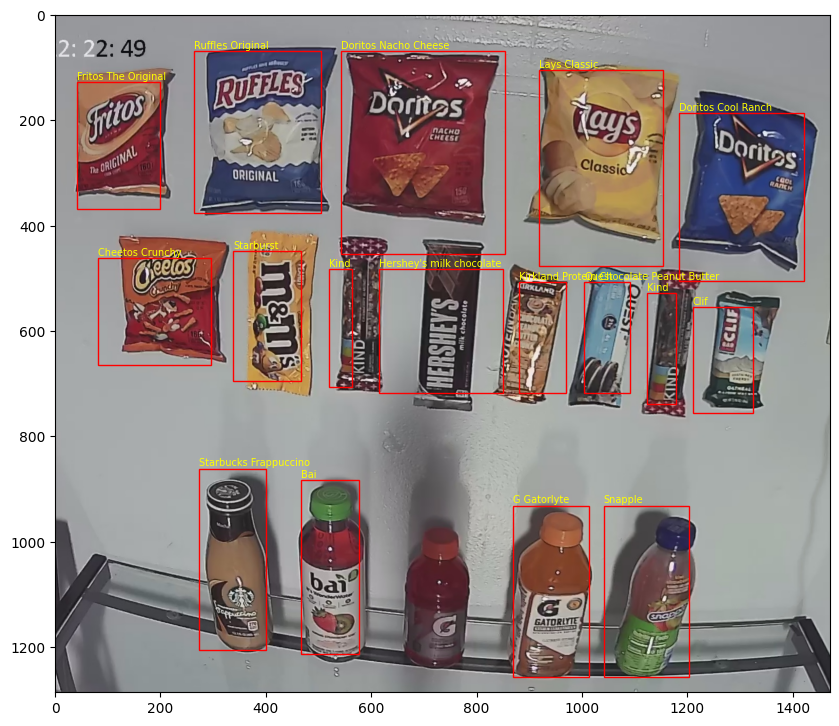

In [202]:
llm_responses.append(make_api_call(img_desc_prompt, images[0], gemini_model))
print(llm_responses[-1].usage_metadata)
text_content = getattr(llm_responses[-1], "text")
print(gemini_model.model_name)
print(text_content)
parse_and_plot_llm_output(text_content, images[0])

prompt_token_count: 312
candidates_token_count: 541
total_token_count: 853

models/gemini-1.5-pro
Utz Potato Chips [64 395 158 455]
Doritos Spicy Nacho [59 464 162 534]
Doritos Nacho Cheese [63 542 162 627]
Doritos Cool Ranch [63 625 164 694]
Lays Classic [205 271 303 342]
Combos Pizzeria Pretzel [213 347 315 414]
Combos Cheddar Cheese Pretzel [216 423 316 491]
Sun Chips Harvest Cheddar [202 503 313 569]
Sun Chips Original [205 582 316 646]
Coca-Cola [475 328 522 369]
Coca-Cola [492 371 539 410]
Dr Pepper [475 412 523 451]
Dr Pepper [492 452 539 492]
Snapple [475 495 523 533]
Sprite [492 536 539 575]
Gatorade [475 576 522 615]
Gatorade [492 618 539 658]
Nesquik Chocolate Milk [568 328 615 369]
Crystal Light Peach Iced Tea [568 371 615 410]
Clearly Canadian Orchard Peach [568 412 615 451]
Wholesome Dairy Milk [568 452 615 492]
Minute Maid Orange Juice [568 495 615 533]
Nantucket Nectars Peach Mango [568 536 615 575]
Lipton Brisk Lemon Iced Tea [568 576 615 615]
Arizona Iced Tea Green Te

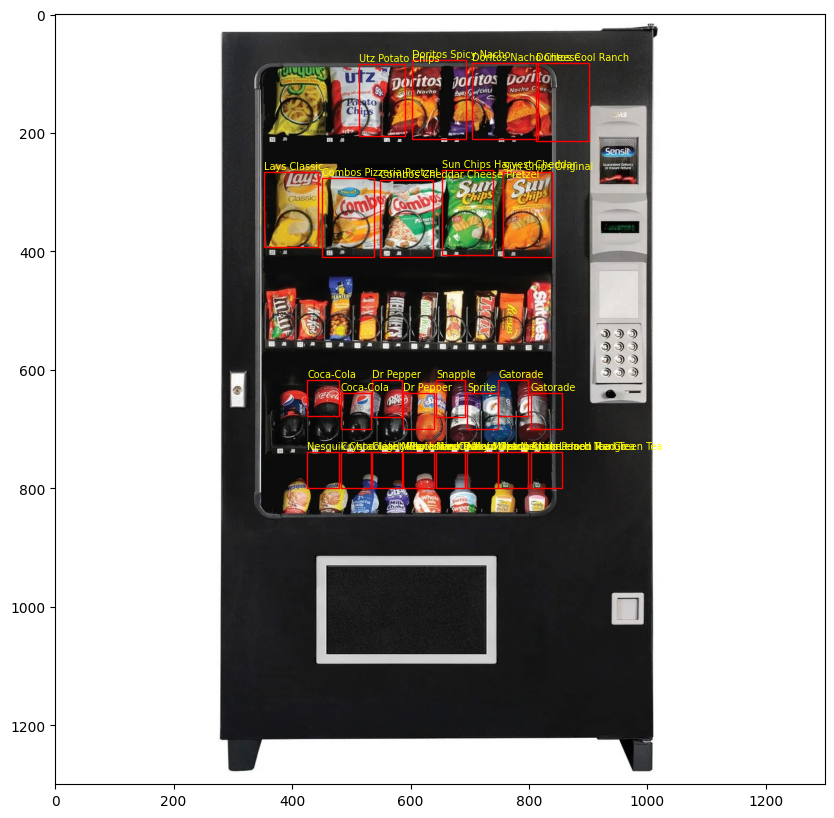

In [203]:
llm_responses.append(make_api_call(img_desc_prompt, images[1], gemini_model))
print(llm_responses[-1].usage_metadata)
text_content = getattr(llm_responses[-1], "text")
print(gemini_model.model_name)
print(text_content)
parse_and_plot_llm_output(text_content, images[1])

prompt_token_count: 312
candidates_token_count: 546
total_token_count: 858

models/gemini-1.5-pro
Boom Chicka Pop, Sweet & Salty Kettle Corn [155 185 251 291]
Skinny Pop, [161 303 245 386]
Sun Chips, Harvest Cheddar [164 454 249 558]
Lays, [164 611 249 693]
All Corners, Kettle Corn [161 728 247 815]
Cheetos, [335 219 418 298]
Garden of Eatin, [337 330 416 415]
Angie's Boom Chicka Pop, [340 453 418 534]
Sun Chips, Original [342 558 419 639]
Wild Nature, [340 671 416 746]
Lance, [343 767 417 818]
Clif, Chocolate Chip [462 233 539 311]
Kind, [465 332 538 414]
Reese's, [463 438 539 511]
Kind, [465 540 538 616]
Kind, [467 642 537 717]
Lance, Nutter Butter [467 739 537 817]
Dr Pepper, Diet [809 233 885 311]
Dr Pepper, Diet [810 334 887 413]
Coca Cola, [812 437 887 516]
Dasani, [811 541 888 616]
Snapple, [814 641 888 716]
Hint, [814 741 889 814]
Snapple, [815 743 889 813]
Peace Tea, [815 744 889 814]

{'product': 'Salty Kettle Corn', 'bbox': (155, 185, 251, 291)}
{'product': 'Harvest Cheddar'

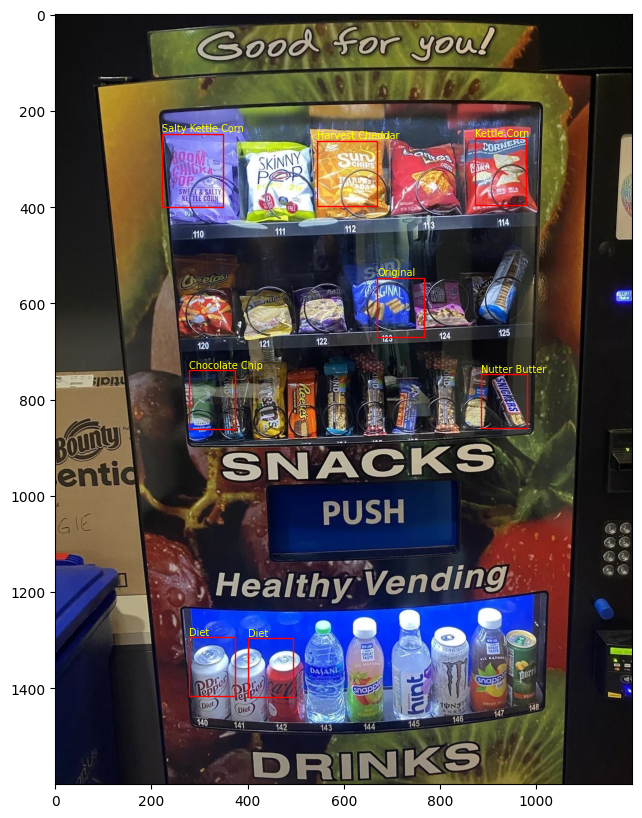

In [204]:
llm_responses.append(make_api_call(img_desc_prompt, images[2], gemini_model))
print(llm_responses[-1].usage_metadata)
text_content = getattr(llm_responses[-1], "text")
print(gemini_model.model_name)
print(text_content)
parse_and_plot_llm_output(text_content, images[2])

prompt_token_count: 312
candidates_token_count: 853
total_token_count: 1165

models/gemini-1.5-pro
Funyuns Onion Flavored Rings [16, 75, 168, 241] 
Utz Potato Chips [16, 257, 168, 412]
Doritos Spicy Nacho [19, 428, 168, 601]
Doritos Spicy Sweet Chili [16, 619, 168, 787]
Doritos Nacho Cheese [19, 798, 168, 973]
Lays Classic [247, 78, 415, 244] 
Combos Cheddar Cheese Pretzel [250, 256, 412, 419] 
Combos Pizzeria Pretzel [247, 429, 412, 601] 
Sun Chips French Onion [247, 619, 415, 787]
Sun Chips Cheddar Cheese [250, 798, 415, 969] 
M&M's [493, 78, 625, 156]
KitKat [493, 169, 622, 241]
Planters [493, 256, 622, 328] 
Austin [496, 341, 625, 412] 
Hershey's [496, 428, 625, 501] 
Milky Way [496, 514, 625, 585] 
Twix [493, 598, 625, 670] 
Reese's [496, 683, 625, 756] 
Skittles [496, 769, 625, 969]
Coca-Cola [678, 81, 821, 159] 
Coca-Cola [678, 172, 821, 250] 
Pepsi [678, 263, 821, 335]
Dr Pepper [681, 348, 821, 511]
Sunkist [678, 524, 821, 601]
[unintelligible] [678, 614, 821, 686]
Gatorade [67

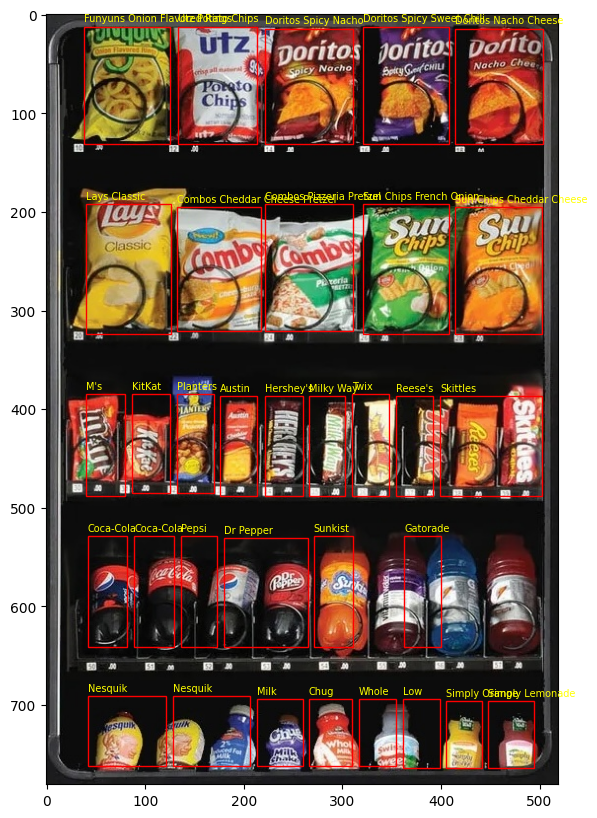

In [206]:
llm_responses.append(make_api_call(img_desc_prompt, images[3], gemini_model))
print(llm_responses[-1].usage_metadata)
text_content = getattr(llm_responses[-1], "text")
print(gemini_model.model_name)
print(text_content)
parse_and_plot_llm_output(text_content, images[3])

prompt_token_count: 312
candidates_token_count: 678
total_token_count: 990

models/gemini-1.5-pro
Boom Chicka Pop Sweet & Salty Kettle Corn [33, 35, 201, 189]
Skinny Pop [60, 233, 206, 385]
Sun Chips Harvest Cheddar [56, 406, 209, 570]
On The Border Cantina Thins [46, 594, 211, 773]
Off The Eaten Path [39, 784, 214, 958]
Cheetos [274, 41, 421, 198]
Late July [280, 214, 418, 371]
That's it [280, 374, 416, 516]
Sun Chips Original [259, 520, 426, 661]
Second Nature [277, 671, 423, 807]
Annie's [256, 827, 418, 956]
Clif Bar [442, 66, 727, 130]
Kind [436, 165, 730, 236]
Nature Valley [439, 249, 727, 314]
Reese's [448, 337, 733, 403]
Kind [436, 428, 724, 491]
LaraBar [442, 518, 733, 587]
Kind [442, 608, 733, 674]
Lance [433, 783, 733, 856]
Snickers [433, 879, 738, 956]
Dr Pepper Diet [858, 78, 975, 188]
Dr Pepper Diet [861, 195, 978, 298]
Coca Cola [864, 308, 981, 406]
Dasani [800, 384, 972, 498]
Snapple [797, 502, 975, 599]
Hint [797, 608, 975, 696]
Monster [797, 716, 972, 799]
Snapple [797

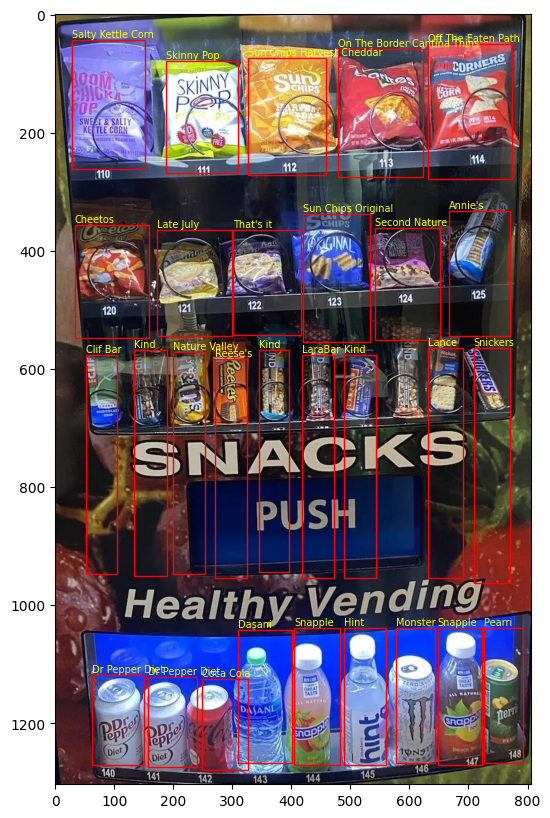

In [207]:
llm_responses.append(make_api_call(img_desc_prompt, images[4], gemini_model))
print(llm_responses[-1].usage_metadata)
text_content = getattr(llm_responses[-1], "text")
print(gemini_model.model_name)
print(text_content)
parse_and_plot_llm_output(text_content, images[4])

In [195]:
#@title Gemini-1.5-Pro Detection Results
# Note: Standard IoU to count a detection as True Positive is atleast 50%.
# I use a lenient measure here by counting detection as TP if any overlap between product and bounding box.
print("Gemini-1.5-Pro Detection Results")
print(f"\nMetrics for {img_fname1}")
# The Gemini Pro detected 17 of the 18 FoodnBev packages on this image and 1 was missed. All these 17 products were correctly identified.
detector_out = """
TP TP TP TP TP
TP TP TP TP TP TP TP TP
TP TP FN TP TP
"""
print_detection_metrics(detector_out)

print(f"\nMetrics for {img_fname2}")
detector_out = """
FN TP TP TP TP
TP TP TP TP TP
FN FN FN FN FN FN FN FN FN FN
FP TP FP TP FP FP TP FN
TP FP FP FN TP FP FP FP
"""
print_detection_metrics(detector_out)

print(f"\nMetrics for {img_fname3}")
detector_out = """
TP TP TP TP TP
TP FN FN TP FN FN
TP FN FN TP TP FP FN FN TP TP
TP TP TP TP FP FP TP FN
"""
print_detection_metrics(detector_out)

# **Good zero shot object classification performance by this Large Multimodal Model (LMM).**

Gemini-1.5-Pro Detection Results

Metrics for vending2.jpg
TP: 17, FP: 0, TN: 0, FN: 1
Accuracy: 94.44%
Precision: 100.00%
Recall: 94.44%
F1 Score: 97.14%

Metrics for vending3.jpg
TP: 14, FP: 9, TN: 0, FN: 13
Accuracy: 38.89%
Precision: 60.87%
Recall: 51.85%
F1 Score: 56.00%

Metrics for vending5.jpg
TP: 17, FP: 3, TN: 0, FN: 9
Accuracy: 58.62%
Precision: 85.00%
Recall: 65.38%
F1 Score: 73.91%


### Results Summary

